In [67]:
! pip install langchain langgraph langchain-anthropic

In [68]:
import getpass
import os
if "ANTHROPIC_API_KEY" not in os.environ:
    os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("Enter your Anthropic API key: ")


In [69]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model="claude-3-5-sonnet-20241022", temperature=0)

In [70]:
import sqlite3

def recreate_appointments_table():
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute("DROP TABLE IF EXISTS appointments")
    c.execute('''
        CREATE TABLE appointments (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            patient_name TEXT,
            age INTEGER,
            symptoms TEXT,
            doctor TEXT,
            date TEXT,
            time TEXT
        )
    ''')
    conn.commit()
    conn.close()

recreate_appointments_table()

doctor_info = {
    "Dr. Rahul Mehra (Dermatologist)": {
        "symptoms": ["skin rash", "acne", "eczema"],
        "schedule": ["10:00", "11:00", "14:00"]
    },
    "Dr. Alice Smith (Neurologist)": {
        "symptoms": ["headache", "dizziness"],
        "schedule": ["09:00", "13:00", "15:00"]
    },
    "Dr. John Lee (General Physician)": {
        "symptoms": ["fever", "body ache", "cold"],
        "schedule": ["10:00", "12:00", "16:00"]
    },
    "Dr. Priya Patel (General Physician)": {
        "symptoms": ["general issues"],
        "schedule": ["09:30", "11:30", "14:30"]
    },
    "Dr. Emily Wong (Pulmonologist)": {
        "symptoms": ["cough", "shortness of breath"],
        "schedule": ["10:00", "12:00", "16:00"]
    }
}


In [71]:
# state schema defined to hold info
from pydantic import BaseModel, Field
from typing import Optional, Literal
# from typing import Dict, Any

class PatientDetails(BaseModel):
    name: Optional[str]
    age: Optional[int]
    symptoms: Optional[str]

class AppointmentDetails(BaseModel):
    date: Optional[str]
    time: Optional[str]
    

class State(BaseModel):
    user_input: str
    patient_details: Optional[PatientDetails] = None
    appointment_details: Optional[AppointmentDetails] = None
    intent: Optional[str] = None
    next_action: Optional[str] = None
    has_history: Optional[bool] = None
    already_has_appointment: Optional[bool] = None
    is_available: Optional[bool] = None
    doctor_recommendation: Optional[str] = None
    final_response: Optional[str] = None
    


In [72]:
# define structured outputs to pass data from llm based step
class ExtractedEntitiesOutput(BaseModel):
    patient_details: PatientDetails = Field(
        description="Information about the patient, including name, age, and symptoms."
    )
    appointment_details: AppointmentDetails = Field(
        description="Preferred appointment date and time from the user."
    )

class IntentClassifierOutput(BaseModel):
    intent: str = Field(
        description="The tool name that should be used to handle the user's question."
    )
    intent_classifier_analysis: Optional[str] = Field(
        default=None, description="A summary of the intent classifier."
    )

class RoutingDecisionOutput(BaseModel):
    next_action: Literal[
        "collect_missing_info"
        "check_patient_history"
        "check_existing_appointment"
        "cancel_appointment"
        "reschedule_appointment"
        "recommend_doctor"
        "schedule_appointment"
        "check_doctor_availability"
        "generate_response"

    ] = Field(
        description="The next step the agent should take in the workflow."
    )

In [73]:
#  prompt used to guide llm 
from langchain_core.prompts import ChatPromptTemplate

entity_prompt = ChatPromptTemplate.from_template("""
You are a helpful assistant that extracts patient and appointment info.

Extract the following from the input:
- Name (if available or use a placeholder like "Unknown")
- Age (if mentioned or leave as null)
- Symptoms
- Date and Time (for the appointment)

Return as JSON like this:
{{
  "patient_details": {{
    "name": "John Doe",
    "age": 30,
    "symptoms": "headache"
  }},
  "appointment_details": {{
    "date": "2023-10-20",
    "time": "15:00"
  }}
}}

Input: {input}
""")

intent_prompt = ChatPromptTemplate.from_template("""
You are an intent classification assistant for a hospital receptionist agent.  
Your task is to classify the user's intent into one of the following categories:

- "collect_missing_info"
- "check_patient_history"
- "check_existing_appointment"
- "cancel_appointment"
- "reschedule_appointment"
- "recommend_doctor"
- "schedule_appointment"
- "check_doctor_availability"
- "generate_response"

Only return one intent from the list above that best matches the user's request.

User Input: {input}

Intent:
""")


In [74]:
# every function take a state and return and update it.
def state_initializer(state: dict) -> State:
    return State(user_input=state.user_input)

def entity_extractor(state: State) -> State:
    prompt = entity_prompt.format(input=state.user_input)
    response = llm.invoke(prompt).content

    import json
    parsed = json.loads(response)

    state.patient_details = PatientDetails(**parsed.get("patient_details", {}))
    state.appointment_details = AppointmentDetails(**parsed.get("appointment_details", {}))
    return {
        "patient_details":state.patient_details,
        "appointment_details":state.appointment_details
    }

def intent_classifier(state: State) -> State:
    prompt = intent_prompt.format(input=state.user_input)
    state.intent = llm.invoke(prompt).content.strip()
    return {
        "intent":state.intent
    }

# def agent_router(state: State) -> State:
#     prompt = router_prompt.format(
#         intent=state.intent,
#     )
#     response = llm.invoke(prompt).content.strip()
#     state.next_action = response
#     return state

In [75]:
def agent_router(state: State) -> State:
    intent = state.intent.lower().strip() if state.intent else ""
    symptom = getattr(state.patient_details, "symptoms", None)
    time = getattr(state.appointment_details, "time", None)

    if intent == "recommend_doctor":
        if symptom and time:
            state.next_action = "recommend_doctor"
        else:
            state.next_action = "collect_missing_info"

    elif intent == "check_existing_appointment":
        state.next_action = "check_existing_appointment"

    elif intent == "schedule_appointment":
        state.next_action = "check_existing_appointment"

    elif intent == "cancel_appointment":
        state.next_action = "cancel_appointment"

    elif intent == "reschedule_appointment":
        state.next_action = "reschedule_appointment"

    elif intent == "check_patient_history":
        state.next_action = "check_patient_history"

    elif intent == "check_doctor_availability":
        state.next_action = "check_doctor_availability"

    elif intent == "generate_response":
        state.next_action = "generate_response"

    else:
        state.next_action = "collect_missing_info"

    return state


In [76]:
# def recommend_doctor(state: State) -> State:
#     symptom = state.patient_details.symptoms.lower().strip() if state.patient_details and state.patient_details.symptoms else None
#     appointment_time = state.appointment_details.time.strip() if state.appointment_details and state.appointment_details.time else None

#     if not symptom or not appointment_time:
#         state.doctor_recommendation = "Missing symptom or appointment time."
#         state.final_response = "Please provide both a symptom and a preferred time to get a doctor recommendation."
#         return state

    # for doctor_name, info in doctor_info.items():
    #     if symptom in [s.lower() for s in info["symptoms"]] and appointment_time in info["schedule"]:
    #         recommendation = f"{doctor_name} is available at {appointment_time} for your symptom '{symptom}'."
    #         state.doctor_recommendation = recommendation
    #         state.final_response = recommendation + " Would you like to proceed with booking?"
    #         return state

    # state.doctor_recommendation = f"No doctor available for '{symptom}' at '{appointment_time}'."
    # state.final_response = f"Unfortunately, no doctor is available at {appointment_time} for your symptom '{symptom}'. Please try a different time."
#     return state


In [77]:
def recommend_doctor(state: State) -> State:
    symptom = (
        state.patient_details.symptoms.lower().strip()
        if state.patient_details and state.patient_details.symptoms
        else None
    )
    appointment_time = (
        state.appointment_details.time.strip()
        if state.appointment_details and state.appointment_details.time
        else None
    )

    if not symptom or not appointment_time:
        state.doctor_recommendation = None
        state.final_response = "Please provide both a symptom and a preferred time to get a doctor recommendation."
        return state

    for doctor_name, info in doctor_info.items():
        if symptom in [s.lower() for s in info.get("symptoms", [])]:
            state.doctor_recommendation = {"doctor_name": doctor_name}
            return state

    state.doctor_recommendation = None
    state.final_response = f"Sorry, no doctor is available for the symptom '{symptom}'."
    return state


In [78]:
# def collect_missing_info(state: State) -> State:
#     missing = []
#     if not state.patient_details.name:
#         missing.append("name")
#     if not state.patient_details.symptoms:
#         missing.append("symptoms")
#     if not state.appointment_details.date or not state.appointment_details.time:
#         missing.append("appointment date/time")
    
#     state.final_response = f"Please provide the following missing info: {', '.join(missing)}"
#     return state


In [79]:
def collect_missing_info(state: State) -> State:
    missing = []

    patient = state.patient_details or PatientDetails()
    appointment = state.appointment_details or AppointmentDetails()

    if not patient.name:
        missing.append("your name")
    if not patient.symptoms:
        missing.append("your symptoms or reason for visit")
    if not appointment.date:
        missing.append("preferred appointment date")
    if not appointment.time:
        missing.append("preferred appointment time")


    if missing:
        state.final_response = (
            "To proceed with your request, could you please provide the following information: "
            + ", ".join(missing)
            + "?"
        )
    else:
        state.final_response = "Thank you! I have all the details I need to help you."

    state.patient_details = patient
    state.appointment_details = appointment

    return state


In [80]:
# def check_patient_history(state: State) -> State:
#     return state

In [81]:
def check_existing_appointment(state: State) -> State:
    conn = sqlite3.connect("hospital.db")
    cursor = conn.cursor()
    cursor.execute("SELECT * FROM appointments WHERE patient_name=? AND date=?",
                   (state.patient_details.name, state.appointment_details.date))
    record = cursor.fetchone()
    state.already_has_appointment = record is not None
    conn.close()
    return state



In [82]:
def cancel_appointment(state: State) -> State:
    name = state.patient_details.name
    date = state.appointment_details.date
    time = state.appointment_details.time

    conn = sqlite3.connect("hospital.db")
    cursor = conn.cursor()

    cursor.execute("SELECT * FROM appointments WHERE patient_name = ? AND date = ? AND time =?", (name, date, time))
    if cursor.fetchone():
        cursor.execute("DELETE FROM appointments WHERE patient_name = ? AND date = ? AND time =?", (name, date, time))
        conn.commit()
        state.final_response = f"Appointment on {date} at{time} for {name} has been cancelled."
    else:
        state.final_response = f"No appointment found for {name} at{time} on {date}."

    conn.close()
    return state

In [83]:
# def check_doctor_availability(state: State) -> State:
#     doctor_entry = state.doctor_recommendation
#     appointment_time = state.appointment_details.time

#     if isinstance(doctor_entry, dict):
#         doctor_name = doctor_entry.get("doctor_name")
#         available_times = doctor_info.get(doctor_name, {}).get("schedule", [])
#         state.is_available = appointment_time in available_times
#     else:
#         state.is_available = False

#     return state



In [84]:
import re

def check_doctor_availability(state: State) -> State:
    user_input = state.user_input.lower()
    appointment_time = (
        state.appointment_details.time.strip()
        if state.appointment_details and state.appointment_details.time
        else None
    )
    appointment_date = (
        state.appointment_details.date.strip()
        if state.appointment_details and state.appointment_details.date
        else None
    )

    doctor_match = re.search(r"dr\.?\s+[a-z]+\s+[a-z]+", user_input, re.IGNORECASE)
    doctor_name = doctor_match.group(0).strip().title() if doctor_match else None

    if not doctor_name or not appointment_time or not appointment_date:
        state.is_available = False
        state.final_response = "Please provide the doctor's full name, date, and time to check availability."
        return state

    matched_doctor_key = next((key for key in doctor_info if doctor_name in key), None)

    if not matched_doctor_key:
        state.is_available = False
        state.final_response = f"Could not find a doctor named '{doctor_name}' in our system."
        return state
    
    available_times = doctor_info[matched_doctor_key]["schedule"]
    if appointment_time not in available_times:
        state.is_available = False
        state.final_response = f"{matched_doctor_key} does not work at {appointment_time}. Please choose another time."
        return state

    try:
        conn = sqlite3.connect("hospital.db")
        cursor = conn.cursor()

        cursor.execute("""
            SELECT COUNT(*) FROM appointments
            WHERE doctor = ? AND date = ? AND time = ?
        """, (matched_doctor_key, appointment_date, appointment_time))

        count = cursor.fetchone()[0]
        conn.close()

        if count > 0:
            state.is_available = False
            state.final_response = f"{matched_doctor_key} is already booked at {appointment_time} on {appointment_date}."
        else:
            state.is_available = True
            state.final_response = f"{matched_doctor_key} is available at {appointment_time} on {appointment_date}. Would you like to book it?"

    except Exception as e:
        state.is_available = False
        state.final_response = f"An error occurred while checking availability: {str(e)}"

    return state


In [85]:
def schedule_appointment(state: State) -> State:
    if not state.appointment_details or not state.patient_details:
        state.final_response = "Missing appointment or patient details."
        return state
    if state.already_has_appointment:
        state.final_response = "You already have an appointment on this date."
        return state
    name = state.patient_details.name or "the patient"
    age = state.patient_details.age or 0
    symptom = state.patient_details.symptoms.lower().strip() if state.patient_details.symptoms else "N/A"
    date = state.appointment_details.date
    time = state.appointment_details.time
    doctor = None
    
    for doc_name, details in doctor_info.items():
        if symptom in [s.lower() for s in details["symptoms"]] and time in details["schedule"]:
            doctor = doc_name
            break

    if not doctor:
        state.final_response = f"Sorry, no doctor is available for '{symptom}' at {time}."
        return state

    # Save in database
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute('''
        INSERT INTO appointments (patient_name, age, symptoms, doctor, date, time)
        VALUES (?, ?, ?, ?, ?, ?)
    ''', (name, age, symptom, doctor, date, time))
    conn.commit()
    conn.close()

    state.final_response = (
        f"Appointment confirmed!\n"
        f"Patient: {name} (Age: {age})\n"
        f"Reason: {symptom}\n"
        f"Doctor: {doctor}\n"
        f"Date: {date}\n"
        f"Time: {time}"
    )
    return state


In [ ]:
# def reschedule_appointment(state: State) -> State:
#     name = state.patient_details.name
#     date = state.appointment_details.date
#     time = state.appointment_details.time

#     if not state.already_has_appointment:
#         state.final_response = "You don't have an existing appointment to reschedule."
#         return {"already_has_appointment": state.already_has_appointment}

#     if not (date and time):
#         state.final_response = "Please provide the new date and time to reschedule your appointment."
#         return state

#     user_input = state.user_input.lower() 
#     doctor_match = re.search(r"dr\.?\s+[a-z]+\s+[a-z]+", user_input, re.IGNORECASE)
#     doctor_name = doctor_match.group(0).strip().title() if doctor_match else None

#     if not doctor_name:
#         state.final_response = "Please mention the doctor’s full name to reschedule the appointment."
#         return state

#     matched_doctor_key = next((key for key in doctor_info if doctor_name in key), None)

#     if not matched_doctor_key:
#         state.final_response = f"Could not find a doctor named '{doctor_name}' in our system."
#         return state

#     available_times = doctor_info[matched_doctor_key]["schedule"]
#     if time not in available_times:
#         state.final_response = f"{matched_doctor_key} does not work at {time}. Please choose another time."
#         return state

#     try:
#         conn = sqlite3.connect("hospital.db")
#         cursor = conn.cursor()
#         cursor.execute("""
#             SELECT COUNT(*) FROM appointments
#             WHERE doctor = ? AND date = ? AND time = ?
#         """, (matched_doctor_key, date, time))
#         count = cursor.fetchone()[0]

#         if count > 0:
#             state.final_response = f"{matched_doctor_key} is already booked at {time} on {date}. Please choose a different time."
#             state.is_available = False
#             conn.close()
#             return state

#         cursor.execute("""
#             DELETE FROM appointments
#             WHERE patient_name = ? 
#         """, (name,))
#         conn.commit()

#         age = state.patient_details.age or 0
#         symptom = state.patient_details.symptoms.lower().strip() if state.patient_details.symptoms else "N/A"

#         cursor.execute('''
#             INSERT INTO appointments (patient_name, age, symptoms, doctor, date, time)
#             VALUES (?, ?, ?, ?, ?, ?)
#         ''', (name, age, symptom, matched_doctor_key, date, time))
#         conn.commit()
#         conn.close()

#         state.final_response = (
#             f"Your appointment has been rescheduled with {matched_doctor_key} "
#             f"on {date} at {time}.\nPatient: {name}, Reason: {symptom}."
#         )
#         state.is_available = True
#         return state

#     except Exception as e:
#         state.final_response = f"An error occurred while rescheduling: {str(e)}"
#         state.is_available = False
#         return state


In [ ]:
def reschedule_appointment(state: State)->State:
    if 
    return state

In [87]:
def generate_response(state: State) -> State:
    return state


In [88]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(State)

# Define all nodes
workflow.add_node("state_initializer", state_initializer)
workflow.add_node("entity_extractor", entity_extractor)
workflow.add_node("intent_classifier", intent_classifier)
workflow.add_node("agent_router", agent_router)
workflow.add_node("collect_missing_info", collect_missing_info)
workflow.add_node("check_existing_appointment", check_existing_appointment)
workflow.add_node("recommend_doctor", recommend_doctor)
workflow.add_node("cancel_appointment", cancel_appointment)
workflow.add_node("reschedule_appointment", reschedule_appointment)
# workflow.add_node("collect_info_from_user_input", collect_info_from_user_input)
workflow.add_node("check_doctor_availability", check_doctor_availability)
workflow.add_node("schedule_appointment", schedule_appointment)
workflow.add_node("generate_response", generate_response)

workflow.set_entry_point("state_initializer")
workflow.add_edge("state_initializer", "entity_extractor")
workflow.add_edge("state_initializer", "intent_classifier")

workflow.add_edge("entity_extractor", "agent_router")
workflow.add_edge("intent_classifier", "agent_router")

# Conditional routing from router
workflow.add_conditional_edges(
    "agent_router",
    lambda state: state.next_action or "generate_response",
    {
        "collect_missing_info": "collect_missing_info",
        "check_existing_appointment": "check_existing_appointment",
        "cancel_appointment": "cancel_appointment",
        "reschedule_appointment": "reschedule_appointment",
        "recommend_doctor": "recommend_doctor",
        "schedule_appointment":"schedule_appointment",
        "check_doctor_availability": "check_doctor_availability",
        "generate_response": "generate_response",
    }
)

workflow.add_edge("collect_missing_info", "generate_response")
# workflow.add_edge("check_patient_history", "generate_response")
workflow.add_edge("cancel_appointment", "generate_response")
workflow.add_edge("reschedule_appointment", "generate_response")
workflow.add_edge("recommend_doctor", "generate_response")
# workflow.add_edge("check_existing_appointment", "collect_info_from_user_input")

workflow.add_conditional_edges(
    "check_existing_appointment",
    lambda state: (
        "generate_response" if getattr(state, "already_has_appointment", False)
        else "schedule_appointment"
    ),
    {
        "schedule_appointment": "schedule_appointment",
        "generate_response": "generate_response"
    }
)

workflow.add_conditional_edges(
    "check_doctor_availability",
    lambda state: (
        "schedule_appointment" if getattr(state, "is_available", False)
        else "generate_response"
    ),
    {
        "schedule_appointment": "schedule_appointment",
        "generate_response": "generate_response"
    }
)

workflow.add_conditional_edges(
    "reschedule_appointment",
    lambda state: (
        "cancel_appointment" if getattr(state, "is_available", False)
        else (
            "schedule_appointment" if not getattr(state, "already_has_appointment", False)
            else "generate_response"
        )
    ),
    {
        "cancel_appointment": "cancel_appointment",
        "schedule_appointment": "schedule_appointment",
        "generate_response": "generate_response"
    }
)


workflow.add_edge("schedule_appointment", "generate_response")
workflow.add_edge("generate_response", END)


In [89]:
app = workflow.compile()

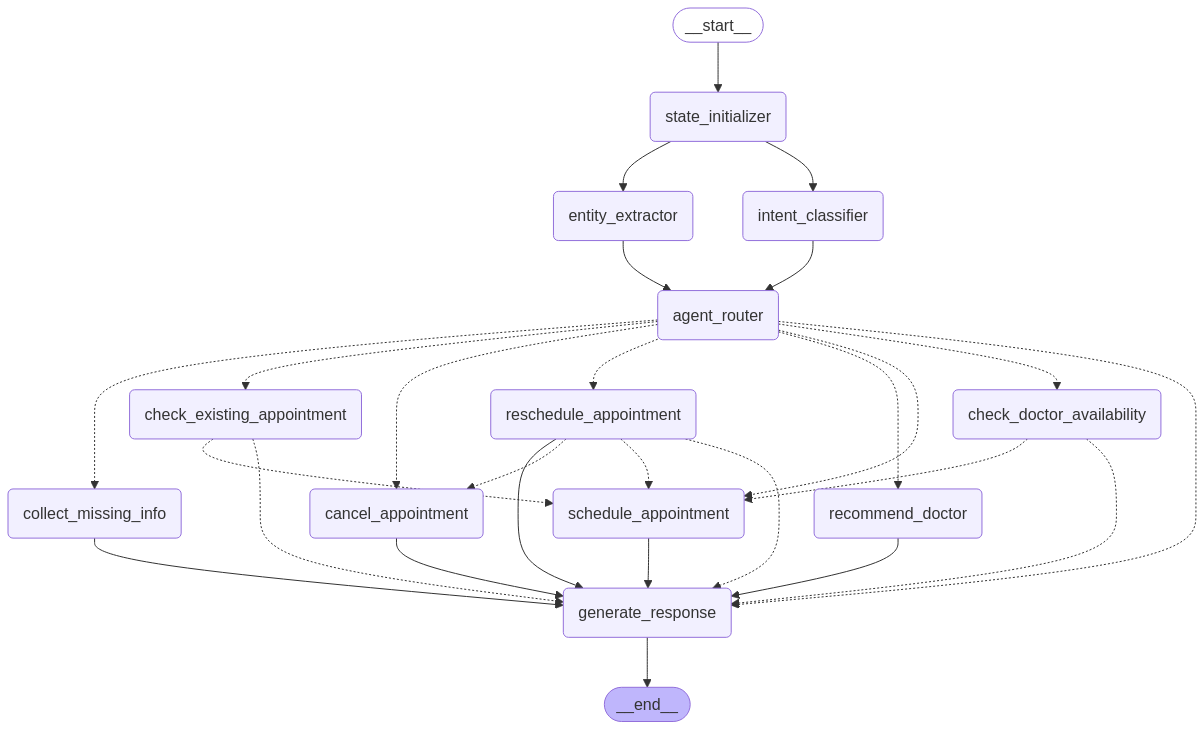

In [90]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [94]:
# final_state = app.invoke({"user_input": "My name is vaishu my age is 28 and I need to see a doctor for cough on 22-03-2025 at 10:00"})
# final_state
# final_state = app.invoke({"user_input": "Hi my name is Vaishnavi and my age is 28 and I have cough do I have any existing appointment on 23-03-2025 at 10:00?"})
# final_state
# final_state = app.invoke({"user_input": "Hi my name is Sahil and I am 25 years old and I have cough tell me  Dr. Emily Wong is available on 22-03-2025 at 10:00."})
# final_state
# final_state = app.invoke({"user_input": "Hi my name is Sahil and I am 25 years old and my appointment is sheduled on 22-03-2025 at 10:00 for cough please cancel this appointment"})
# final_state
# final_state = app.invoke({"user_input": "Hi my name is Sahil, I am 25 years old and please recommend a doctor for cough on 4-4-2025 at 12 "})
# final_state
# final_state = app.invoke({"user_input": "please recommend a doctor for cough"})
# final_state
final_state = app.invoke({"user_input": "please reschedule my appointment on 28-03-2025 at 10 am for skin rash, My details Name=Sakshi, age= 20  "})
final_state

InvalidUpdateError: At key 'user_input': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE

In [92]:


def check_appointments():
    conn = sqlite3.connect("hospital.db")
    c = conn.cursor()
    c.execute("SELECT * FROM appointments")
    rows = c.fetchall()
    conn.close()

    if rows:
        print("Stored Appointments:")
        for row in rows:
            print(row)
    else:
        print("No appointments found.")


In [93]:
check_appointments()


No appointments found.
